In [61]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import Any
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
%load_ext autoreload
%autoreload 2


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"


config = Config()

sys.path.append(str(config.REPO_ROOT))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
from python.src.preprocess import (
    preprocess_rfcc,
)

df_rfcc = pd.read_csv(config.data_dir / "risk_factors_cervical_cancer.csv")
df_rfcc_preprocessed = preprocess_rfcc(df=df_rfcc)
assert df_rfcc.shape[0] == df_rfcc_preprocessed.shape[0]

In [81]:
X = df_rfcc_preprocessed.drop("Biopsy", axis=1)
y = df_rfcc_preprocessed["Biopsy"].map({"Healthy": 0, "Cancer": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


rf_model = RandomForestClassifier(random_state=43)  # random_stateで再現性を確保
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=43)

In [82]:
from sklearn.metrics import roc_auc_score, mean_absolute_error
from python.src.utils import PermutationFeatureImportance

In [85]:
pfi = PermutationFeatureImportance(
    rf_model,
    X=X_test,
    y=y_test,
    var_names=list(X_test.columns),
    metric=lambda y_true, y_pred: 1 - roc_auc_score(y_true, y_pred),
    pred_type="classification",
)

In [86]:
pfi.permutation_feature_importance()

In [87]:
pfi.feature_importance

,var_name,permutation,baseline,difference,ratio
7,Hormonal Contraceptives (years),0.493111,0.393281,0.099831,1.253841
9,IUD (years),0.423405,0.393281,0.030124,1.076597
10,STDs,0.415726,0.393281,0.022445,1.057071
11,STDs (number),0.402710,0.393281,0.009430,1.023977
8,IUD,0.401976,0.393281,0.008696,1.022111
14,STDs: Time since last diagnosis,0.391530,0.393281,-0.001750,0.995549
4,Smokes,0.383286,0.393281,-0.009994,0.974587
5,Smokes (years),0.382213,0.393281,-0.011067,0.971859
12,STDs: Number of diagnosis,0.380294,0.393281,-0.012987,0.966978
13,STDs: Time since first diagnosis,0.373998,0.393281,-0.019283,0.950969


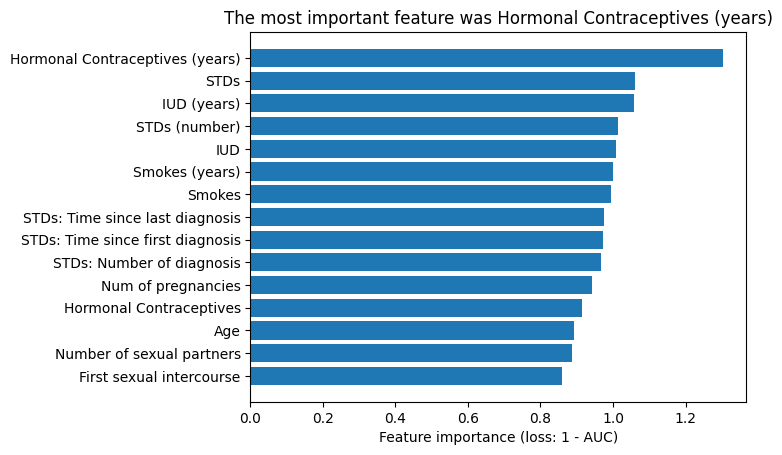

The most important feature was Hormonal Contraceptives (years).


In [58]:
# 特徴量の重要度の計算 (Permutation Feature Importance)
def auc_error(y_true, y_pred_prob):
    return 1 - roc_auc_score(y_true, y_pred_prob)


n_repeats = 30  # permutationの回数
importances = []
for _ in range(n_repeats):
    perm_importances = []
    baseline_proba = rf_model.predict_proba(X_test)[:, 1]
    baseline_loss = auc_error(y_test, baseline_proba)

    for col in X_test.columns:
        X_test_permuted = X_test.copy()
        X_test_permuted[col] = np.random.permutation(X_test_permuted[col])
        permuted_proba = rf_model.predict_proba(X_test_permuted)[:, 1]
        perm_loss = auc_error(y_test, permuted_proba)
        perm_importances.append(perm_loss / baseline_loss)  # lossの増加率
    importances.append(perm_importances)

importances_mean = np.mean(importances, axis=0)
imp_df = pd.DataFrame({"feature": X.columns, "importance": importances_mean})


# 最も重要な特徴量
most_imp = imp_df.loc[imp_df["importance"].idxmax(), "feature"]


# 特徴量の重要度のプロット
sorted_idx = imp_df.sort_values("importance", ascending=True).index
plt.barh(imp_df.loc[sorted_idx, "feature"], imp_df.loc[sorted_idx, "importance"])
plt.xlabel("Feature importance (loss: 1 - AUC)")
plt.title(f"The most important feature was {most_imp}")
plt.show()


print(f"The most important feature was {most_imp}.")

In [88]:
from python.src.preprocess import (
    preprocess_bike_data,
)
from sklearn.svm import SVR

df_bike = pd.read_csv(config.data_dir / "bike+sharing+dataset" / "day.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

In [89]:
df_bike_processed["holiday"] = df_bike_processed["holiday"].map(
    {"HOLIDAY": 1, "NO HOLIDAY": 0}
)
df_bike_processed["season"] = df_bike_processed["season"].map(
    {
        "WINTER": 1,
        "SPRING": 2,
        "SUMMER": 3,
        "FALL": 4,
    }
)
df_bike_processed["workingday"] = df_bike_processed["workingday"].map(
    {"WORKING DAY": 1, "NO WORKING DAY": 0}
)
df_bike_processed["mnth"] = df_bike_processed["mnth"].map(
    {
        "JAN": 1,
        "FEB": 2,
        "MAR": 3,
        "APR": 4,
        "MAY": 5,
        "JUN": 6,
        "JUL": 7,
        "AUG": 8,
        "SEP": 9,
        "OCT": 10,
        "NOV": 11,
        "DEC": 12,
    }
)
df_bike_processed["weekday"] = df_bike_processed["weekday"].map(
    {
        "SUN": 1,
        "MON": 2,
        "TUE": 3,
        "WED": 4,
        "THU": 5,
        "FRI": 6,
        "SAT": 7,
    }
)
df_bike_processed["weathersit"] = df_bike_processed["weathersit"].map(
    {"MISTY": 1, "GOOD": 2, "RAIN/SNOW/STORM": 3}
)
X = df_bike_processed.drop(columns="cnt")
y = df_bike_processed["cnt"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# df_bike_processed_sampled = df_bike_processed.sample(n=300, random_state=42)
# X_sampled = df_bike_processed_sampled.drop(columns="cnt")
# y_sampled = df_bike_processed_sampled["cnt"]

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.fit_transform(X_test), columns=X_test.columns, index=X_test.index
)

svr = SVR()  # Adjust C and epsilon as needed
svr.fit(X_train_scaled, y_train)

SVR()

In [90]:
pfi = PermutationFeatureImportance(
    svr,
    X=X_test_scaled,
    y=y_test,
    var_names=list(X_test_scaled.columns),
    metric=mean_absolute_error,
    pred_type="regression",
)

In [91]:
pfi.permutation_feature_importance()

In [92]:
pfi.feature_importance

,var_name,permutation,baseline,difference,ratio
10,days_since_2011,1697.446588,1691.204083,6.242504,1.003691
1,yr,1697.339744,1691.204083,6.135661,1.003628
7,temp,1695.922585,1691.204083,4.718502,1.002790
0,season,1694.112752,1691.204083,2.908668,1.001720
2,mnth,1693.270968,1691.204083,2.066885,1.001222
8,hum,1692.651065,1691.204083,1.446982,1.000856
6,weathersit,1692.270260,1691.204083,1.066176,1.000630
5,workingday,1692.108744,1691.204083,0.904661,1.000535
9,windspeed,1691.731501,1691.204083,0.527418,1.000312
4,weekday,1691.701231,1691.204083,0.497148,1.000294


In [93]:
svr = SVR()  # Adjust C and epsilon as needed
svr.fit(X_train, y_train)
pfi = PermutationFeatureImportance(
    svr,
    X=X_test,
    y=y_test,
    var_names=list(X_test.columns),
    metric=mean_absolute_error,
    pred_type="regression",
)
pfi.permutation_feature_importance()

pfi.feature_importance

,var_name,permutation,baseline,difference,ratio
10,days_since_2011,1714.004685,1710.040487,3.964198e+00,1.002318
7,temp,1710.046639,1710.040487,6.151681e-03,1.000004
8,hum,1710.041273,1710.040487,7.862303e-04,1.000000
9,windspeed,1710.040832,1710.040487,3.451904e-04,1.000000
2,mnth,1710.040606,1710.040487,1.193630e-04,1.000000
0,season,1710.040523,1710.040487,3.619838e-05,1.000000
1,yr,1710.040506,1710.040487,1.912171e-05,1.000000
6,weathersit,1710.040489,1710.040487,1.683171e-06,1.000000
5,workingday,1710.040487,1710.040487,1.441647e-07,1.000000
3,holiday,1710.040487,1710.040487,2.557726e-08,1.000000


In [55]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = X_train_scaled, X_test_scaled, y_train, y_test

# Create and train the SVR model
model = SVR()
model.fit(X_train, y_train)


def permutation_importance(model, X_test, y_test, metric):
    baseline = metric(y_test, model.predict(X_test))
    importance = []
    for col in X_test.columns:
        X_test_permuted = X_test.copy()
        X_test_permuted[col] = np.random.permutation(X_test_permuted[col])
        permuted_metric = metric(y_test, model.predict(X_test_permuted))
        importance.append(
            permuted_metric - baseline
        )  # Calculate importance as change in metric
    return importance


# Calculate feature importance using MAE
importance = permutation_importance(model, X_test, y_test, mean_absolute_error)

# Create a DataFrame to store feature importances
imp_df = pd.DataFrame({"feature": X.columns, "importance": importance})

# Find the best and worst features based on importance
best_feature = imp_df.loc[imp_df["importance"].idxmax(), "feature"]
worst_feature = imp_df.loc[imp_df["importance"].idxmin(), "feature"]


print(f"Most important feature: {best_feature}")
print(f"Least important feature: {worst_feature}")


# You can further analyze the importance scores, for example, by sorting:
imp_df_sorted = imp_df.sort_values("importance", ascending=False)
print(imp_df_sorted)

Most important feature: days_since_2011
Least important feature: holiday
            feature  importance
10  days_since_2011    6.592337
7              temp    5.648549
1                yr    5.377575
0            season    2.641228
8               hum    1.873963
2              mnth    1.469835
6        weathersit    0.719094
5        workingday    0.677098
9         windspeed    0.533215
4           weekday    0.456381
3           holiday    0.340938


In [ ]:
X